# Choosing the date range for analysis

### **WARNING** - Horizon and warmup effects

You need to be careful when specifying the start and end dates for your analysis (we call this the *analysis range*). You need to consider *horizon and warmup effects*. In the SSU example, each stop is just a few hours and there aren't any patients who arrive before 1/1/1996 and are still in the SSU on 1/1/1996. However, if we were working with data in which the stops are a few days in length (such as on an inpatient nursing unit), we need to think about what start date we should use and exactly how the original dataset was extracted. hillmaker is completely capable of properly accounting for patients who arrive before the specified start date for the analysis as well as those who are discharged after the end date. However, it can only work with the stop data provided and you are responsible for considering warmup effects - a transient phase as occupancy builds to some stochastic steady state. Assume you know that you have stop data that was extracted, say, to include all patients discharged between 1/1/2021 and 12/30/2021 and that each stop might last for several days. You wouldn't want to set your hillmaker start date to 1/1/2021 as the system will appear to start out empty and occupancy will have a transient phase until the system fills to some sort of steady state. The longer the length of stay, the longer this warmup phase will take. You might want to experiment with start dates ranging from a few weeks to a few months **after** your earliest arrival time in your hillmaker stop data to see how long the system takes to reach a steady state. Similarly, if your criteria for selectng the stop data was discharges in 1/1/2021-12/30/2021, your data will **not** contain records for those patients admitted before 12/30/2021 but discharged after 12/30/2021. So, you might want to set your end date for hillmaker to be a few weeks before 12/20/2021.

For our SSU data, we don't need to worry about this as patients only stay a few hours and the SSU typically only houses patients between ~6am-10pm.

In [3]:
import numpy as np
from matplotlib import pyplot as plt

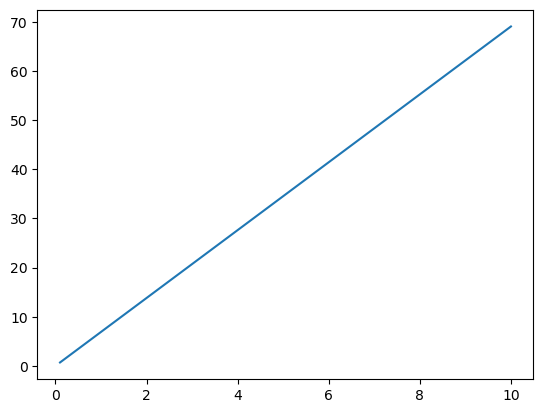

In [7]:
alpha = 0.001
b = np.linspace(start = 0.1, stop = 10.0)

t_star = -np.log(alpha) * b 
plt.plot(b, t_star)
